# Modelling a Pin-Cell

This notebook runs depletion and burnup calculations for a pincell of water with a UO2 rod. It's based on the example from https://github.com/openmc-dev/openmc/wiki/Example-Jupyter-Notebooks

The final goal is to output the burnup matrix A from the depletion step. This is obtained with a modified version of OpenMC, which stores A, dt, and n0 each time that CRAM is solved.

In [2]:
%matplotlib inline
import openmc
import openmc.deplete
import scipy.sparse as sp
import matplotlib.pyplot as plt
import pickle

import sys
sys.path.append("/home/arnau/documents/code/solvers_decay_equation")
from triangularise_matrix import triangularise_matrix
from reduce_stiffness import remove_zeros
from CRAMsolve import CRAM16

depletion_chain = '/home/arnau/documents/code/openmv-dev/chain_endfb71_pwr.xml'

matrix_dir = '/home/arnau/Downloads/A_matrices_from_openmc/'

fs = 15

## Materials

In [2]:
fuel_radius = 0.39
uo2 = openmc.Material(1, "uo2")
uo2.volume = np.pi * fuel_radius**2  # In cm2.
print(uo2)

Material
	ID             =	1
	Name           =	uo2
	Temperature    =	None
	Density        =	None [sum]
	S(a,b) Tables  
	Nuclides       



In [3]:
mat = openmc.Material()
print(mat)

Material
	ID             =	2
	Name           =	
	Temperature    =	None
	Density        =	None [sum]
	S(a,b) Tables  
	Nuclides       



We see that by default it assumes we want an atom fraction.

In [4]:
# Add nuclides to uo2
uo2.add_nuclide('U235', 0.03)  # 3% enriched.
uo2.add_nuclide('U238', 0.97)
uo2.add_nuclide('O16', 2.0)

In [5]:
uo2.set_density('g/cm3', 10.0)

In [6]:
zirconium = openmc.Material(name="zirconium")
zirconium.add_element('Zr', 1.0)
zirconium.set_density('g/cm3', 6.6)

water = openmc.Material(name="h2o")
water.add_nuclide('H1', 2.0)
water.add_nuclide('O16', 1.0)
water.set_density('g/cm3', 1.0)

In [7]:
water.add_s_alpha_beta('c_H_in_H2O')

In [8]:
materials = openmc.Materials([uo2, zirconium, water])

Note that `Materials` is actually a subclass of Python's built-in `list`, so we can use methods like `append()`, `insert()`, `pop()`, etc.

In [9]:
materials = openmc.Materials()
materials.append(uo2)
materials += [zirconium, water]
isinstance(materials, list)

True

In [10]:
materials.export_to_xml()
!cat materials.xml

<?xml version='1.0' encoding='utf-8'?>
<materials>
  <material depletable="true" id="1" name="uo2" volume="0.4778362426110076">
    <density units="g/cm3" value="10.0" />
    <nuclide ao="0.03" name="U235" />
    <nuclide ao="0.97" name="U238" />
    <nuclide ao="2.0" name="O16" />
  </material>
  <material id="3" name="zirconium">
    <density units="g/cm3" value="6.6" />
    <nuclide ao="0.5145" name="Zr90" />
    <nuclide ao="0.1122" name="Zr91" />
    <nuclide ao="0.1715" name="Zr92" />
    <nuclide ao="0.1738" name="Zr94" />
    <nuclide ao="0.028" name="Zr96" />
  </material>
  <material id="4" name="h2o">
    <density units="g/cm3" value="1.0" />
    <nuclide ao="2.0" name="H1" />
    <nuclide ao="1.0" name="O16" />
    <sab name="c_H_in_H2O" />
  </material>
</materials>


### Pin cell geometry

We now have enough knowledge to create our pin-cell. We need three surfaces to define the fuel and clad:

1. The outer surface of the fuel -- a cylinder parallel to the z axis
2. The inner surface of the clad -- same as above
3. The outer surface of the clad -- same as above

These three surfaces will all be instances of `openmc.ZCylinder`, each with a different radius according to the specification.

In [11]:
fuel_outer_radius = openmc.ZCylinder(r=fuel_radius)
clad_inner_radius = openmc.ZCylinder(r=0.40)
clad_outer_radius = openmc.ZCylinder(r=0.46)

With the surfaces created, we can now take advantage of the built-in operators on surfaces to create regions for the fuel, the gap, and the clad:

In [12]:
fuel_region = -fuel_outer_radius
gap_region = +fuel_outer_radius & -clad_inner_radius
clad_region = +clad_inner_radius & -clad_outer_radius

Now we can create corresponding cells that assign materials to these regions. As with materials, cells have unique IDs that are assigned either manually or automatically. Note that the gap cell doesn't have any material assigned (it is void by default).

In [13]:
fuel = openmc.Cell(name='fuel')
fuel.fill = uo2
fuel.region = fuel_region

gap = openmc.Cell(name='air gap')
gap.region = gap_region

clad = openmc.Cell(name='clad')
clad.fill = zirconium
clad.region = clad_region

Finally, we need to handle the coolant outside of our fuel pin. To do this, we create x- and y-planes that bound the geometry.

In [14]:
pitch = 1.26
left = openmc.XPlane(-pitch/2, boundary_type='reflective')
right = openmc.XPlane(pitch/2, boundary_type='reflective')
bottom = openmc.YPlane(-pitch/2, boundary_type='reflective')
top = openmc.YPlane(pitch/2, boundary_type='reflective')

The water region is going to be everything outside of the clad outer radius and within the box formed as the intersection of four half-spaces.

In [15]:
water_region = +left & -right & +bottom & -top & +clad_outer_radius

moderator = openmc.Cell(name='moderator')
moderator.fill = water
moderator.region = water_region

OpenMC also includes a factory function that generates a rectangular prism that could have made our lives easier.

In [16]:
box = openmc.rectangular_prism(width=pitch, height=pitch,
                               boundary_type='reflective')
type(box)

openmc.region.Intersection

Pay attention here -- the object that was returned is NOT a surface. It is actually the intersection of four surface half-spaces, just like we created manually before. Thus, we don't need to apply the unary operator (`-box`). Instead, we can directly combine it with `+clad_or`.

In [17]:
water_region = box & +clad_outer_radius

The final step is to assign the cells we created to a universe and tell OpenMC that this universe is the "root" universe in our geometry. The `Geometry` is the final object that is actually exported to XML.

In [18]:
root_universe = openmc.Universe(cells=(fuel, gap, clad, moderator))

geometry = openmc.Geometry()
geometry.root_universe = root_universe

# or...
geometry = openmc.Geometry(root_universe)
geometry.export_to_xml()
!cat geometry.xml

<?xml version='1.0' encoding='utf-8'?>
<geometry>
  <cell id="1" material="1" name="fuel" region="-1" universe="1" />
  <cell id="2" material="void" name="air gap" region="1 -2" universe="1" />
  <cell id="3" material="3" name="clad" region="2 -3" universe="1" />
  <cell id="4" material="4" name="moderator" region="4 -5 6 -7 3" universe="1" />
  <surface coeffs="0.0 0.0 0.39" id="1" type="z-cylinder" />
  <surface coeffs="0.0 0.0 0.4" id="2" type="z-cylinder" />
  <surface coeffs="0.0 0.0 0.46" id="3" type="z-cylinder" />
  <surface boundary="reflective" coeffs="-0.63" id="4" type="x-plane" />
  <surface boundary="reflective" coeffs="0.63" id="5" type="x-plane" />
  <surface boundary="reflective" coeffs="-0.63" id="6" type="y-plane" />
  <surface boundary="reflective" coeffs="0.63" id="7" type="y-plane" />
</geometry>


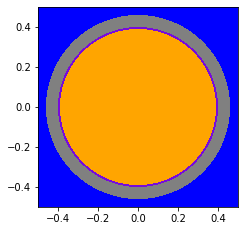

In [19]:
root_universe.plot(colors = {fuel : "orange", water : "blue", clad : "grey"})
plt.show()

## Starting source and settings

The Python API has a module ``openmc.stats`` with various univariate and multivariate probability distributions. We can use these distributions to create a starting source using the ``openmc.Source`` object.

In [20]:
# Create a point source
point = openmc.stats.Point((0, 0, 0))
source = openmc.Source(space=point)

Now let's create a `Settings` object and give it the source we created along with specifying how many batches and particles we want to run.

In [21]:
settings = openmc.Settings()
settings.source = source
settings.batches = 100
settings.inactive = 10
settings.particles = 1000
settings.seed = 42

In [22]:
settings.export_to_xml()
!cat settings.xml

<?xml version='1.0' encoding='utf-8'?>
<settings>
  <run_mode>eigenvalue</run_mode>
  <particles>1000</particles>
  <batches>100</batches>
  <inactive>10</inactive>
  <source strength="1.0">
    <space type="point">
      <parameters>0 0 0</parameters>
    </space>
  </source>
  <seed>42</seed>
</settings>


## Running OpenMC

Running OpenMC from Python can be done using the `openmc.run()` function. This function allows you to set the number of MPI processes and OpenMP threads, if need be.

In [23]:
openmc.run()

                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%%%%%%%%%%
                #####################     %%%%%%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%%
                 #######################     %%%%%%%%%%%%%%%%%
                 #####################

# Depletion

In [24]:
model = openmc.model.Model(geometry = geometry, materials = materials, settings = settings)

operator = openmc.deplete.CoupledOperator(model = model, 
                                          chain_file = depletion_chain)

burnup_time = 365  # Days
timesteps = [burnup_time/2] * 2
mass = np.pi * fuel_radius**2 * uo2.density
power = 5000 * mass / burnup_time  # 5000 Wd/gU * mass(kg) / burnup_time(d), where 5000 Wd/gU = 5 MWd/kgU
# power = 1e-200  # watts. Choose power=1e-200 if you only want depletion, without burnup.
print("power", power/1e6, "MW")

integrator = openmc.deplete.PredictorIntegrator(operator, timesteps, power, timestep_units = 'd')

power 6.545701953575445e-05 MW


In [25]:
integrator.integrate()

[openmc.deplete] t=0.0 s, dt=15768000.0 s, source=65.45701953575445
Hello there, I am saving the burnup matrix A with filename /home/arnau/Downloads/A_matrices_from_openmc/A_0008.npz
and dt and the initial vector n0 with filename /home/arnau/Downloads/A_matrices_from_openmc/dt_n0_0008.txt
The depletion step is 1.57680e+07 seconds
[openmc.deplete] t=15768000.0 s, dt=15768000.0 s, source=65.45701953575445
Hello there, I am saving the burnup matrix A with filename /home/arnau/Downloads/A_matrices_from_openmc/A_0009.npz
and dt and the initial vector n0 with filename /home/arnau/Downloads/A_matrices_from_openmc/dt_n0_0009.txt
The depletion step is 1.57680e+07 seconds
[openmc.deplete] t=31536000.0 (final operator evaluation)


In [26]:
dep = openmc.deplete.Results("depletion_results.h5")

In [27]:
ts, ks = dep.get_keff()
print("times", ts/3600/24, "days")
print("Keffs", ks[:,0])

times [  0.  182.5 365. ] days
Keffs [1.4032786  1.31779138 1.28561852]


In [28]:
with open(matrix_dir + 'nuclide_dictionary.pkl', 'wb') as f:
    pickle.dump(operator.chain.nuclide_dict, f)

# Get matrices

In [35]:
with open(matrix_dir + 'nuclide_dictionary.pkl', 'rb') as f:
    nuclide_dict = pickle.load(f)

In [36]:
nuclides = list(nuclide_dict.keys())
nuclides

['H1',
 'H2',
 'H3',
 'H4',
 'H5',
 'H6',
 'H7',
 'He3',
 'He4',
 'He5',
 'He6',
 'He7',
 'He8',
 'He9',
 'He10',
 'Li4',
 'Li5',
 'Li6',
 'Li7',
 'Li8',
 'Li9',
 'Li10',
 'Li11',
 'Li12',
 'Be5',
 'Be6',
 'Be8',
 'Be9',
 'Be10',
 'Be11',
 'Be12',
 'Be13',
 'Be14',
 'Be15',
 'Be16',
 'B6',
 'B7',
 'B8',
 'B9',
 'B10',
 'B11',
 'B12',
 'B13',
 'B14',
 'B15',
 'B16',
 'B17',
 'B18',
 'B19',
 'C8',
 'C9',
 'C10',
 'C11',
 'C12',
 'C13',
 'C14',
 'C15',
 'C16',
 'C17',
 'C18',
 'C19',
 'C20',
 'C21',
 'C22',
 'N10',
 'N11',
 'N12',
 'N13',
 'N14',
 'N15',
 'N16',
 'N17',
 'N18',
 'N19',
 'N20',
 'N21',
 'N22',
 'N23',
 'N24',
 'N25',
 'O12',
 'O13',
 'O14',
 'O15',
 'O16',
 'O17',
 'O18',
 'O19',
 'O20',
 'O21',
 'O22',
 'O23',
 'O24',
 'O25',
 'O26',
 'O27',
 'O28',
 'F14',
 'F15',
 'F16',
 'F17',
 'F18',
 'F19',
 'F20',
 'F21',
 'F22',
 'F23',
 'F24',
 'F25',
 'F26',
 'F27',
 'F28',
 'F29',
 'F30',
 'F31',
 'Ne16',
 'Ne17',
 'Ne18',
 'Ne19',
 'Ne20',
 'Ne21',
 'Ne22',
 'Ne23',
 'Ne24',
 

## Burnup

In [50]:
# A_bu = sp.load_npz("/home/arnau/Downloads/A_matrices_from_openmc/A_0005.npz").toarray()
A_bu = sp.load_npz("/home/arnau/Downloads/A_matrices_from_openmc/A_0008.npz").toarray()
A_bu

array([[-3.73043620e-12,  1.46431050e-13,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 3.73043620e-12, -1.52352630e-13,  3.53586493e-15, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  5.92158010e-15, -1.78283718e-09, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       ...,
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
        -3.08065414e+03,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00, -3.64814306e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00, -1.69060288e+02]])

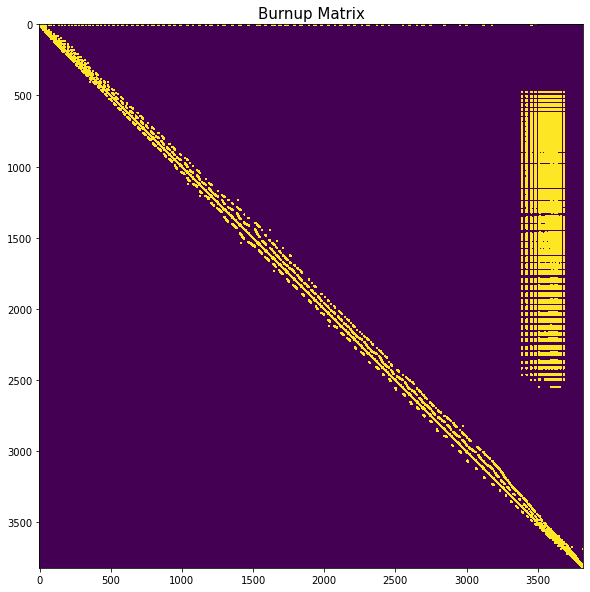

In [51]:
fig,ax = plt.subplots(figsize = (10,10))

ax.imshow(np.abs(A_bu),vmax = 1e-100)
ax.set_title("Burnup Matrix", fontsize = fs)
plt.show()

In [52]:
# We can try to triangularise the matrix, but in theory it shouldn't work because it's a burnup matrix.
B = np.copy(A_bu)
triangularise_matrix(B)

Matrix could not be triangularised after 20 runs.


### Initial and final concentrations, and smaller matrix

isotopes with largest initial concentration
O16 2.13e+22 g/cm3
U235 3.20e+20 g/cm3
U238 1.03e+22 g/cm3
isotopes with final concentration larger than 100000000000.0
H1 2.67e+14 g/cm3
He4 7.28e+16 g/cm3
C13 7.28e+16 g/cm3
C14 1.03e+11 g/cm3
O16 2.13e+22 g/cm3
O17 2.27e+15 g/cm3
Zn67 4.01e+11 g/cm3
Zn68 6.21e+11 g/cm3
Zn70 1.93e+12 g/cm3
Zn72 1.68e+11 g/cm3
Ga69 1.03e+12 g/cm3
Ga71 3.62e+12 g/cm3
Ge72 9.99e+12 g/cm3
Ge73 3.63e+13 g/cm3
Ge74 1.14e+14 g/cm3
Ge75 1.54e+11 g/cm3
Ge76 9.78e+14 g/cm3
Ge77 9.04e+12 g/cm3
Ge78 3.11e+12 g/cm3
As75 3.42e+14 g/cm3
As77 3.15e+13 g/cm3
As78 3.24e+12 g/cm3
As79 6.96e+11 g/cm3
As81 1.83e+11 g/cm3
As82 1.37e+11 g/cm3
As83 1.29e+11 g/cm3
Se76 6.57e+11 g/cm3
Se77 2.47e+15 g/cm3
Se78 6.67e+15 g/cm3
Se79 1.43e+16 g/cm3
Se79_m1 2.96e+11 g/cm3
Se80 4.05e+16 g/cm3
Se81 6.35e+12 g/cm3
Se81_m1 1.44e+12 g/cm3
Se82 1.03e+17 g/cm3
Se83 1.82e+13 g/cm3
Se84 5.16e+12 g/cm3
Se85 9.02e+11 g/cm3
Se86 5.45e+11 g/cm3
Se87 1.24e+11 g/cm3
Br79 7.85e+12 g/cm3
Br81 6.42e+16 g/c

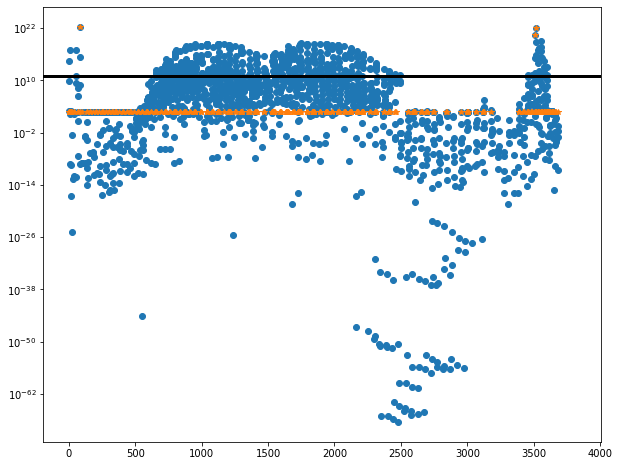

In [70]:
n0 = np.loadtxt("/home/arnau/Downloads/A_matrices_from_openmc/dt_n0_0008.txt", skiprows = 1)
n1 = np.loadtxt("/home/arnau/Downloads/A_matrices_from_openmc/dt_n0_0009.txt", skiprows = 1)
N = len(n0)
# Sanity check initial isotopes:
print("isotopes with largest initial concentration")
for i in range(N):
    if n0[i] > 1e19:
        print(nuclides[i], "{:.2e} g/cm3".format(n0[i]))
        
lim = 1e11
print("isotopes with final concentration larger than", lim)
tot = 0
idxs = []
for i in range(N):
    if n1[i] > lim:
        print(nuclides[i], "{:.2e} g/cm3".format(n1[i]))
        tot += 1
        idxs.append(i)
        
print("Total =", tot)
        
fig,ax = plt.subplots(figsize = (10,8))
ax.plot(n1, 'o')
ax.plot(n0, '*')
ax.axhline(lim, color = 'k', lw = 3)
ax.set_yscale('log')
plt.show()

Removing nuclide H1
Removing nuclide He4
Finally A has shape (442, 442)


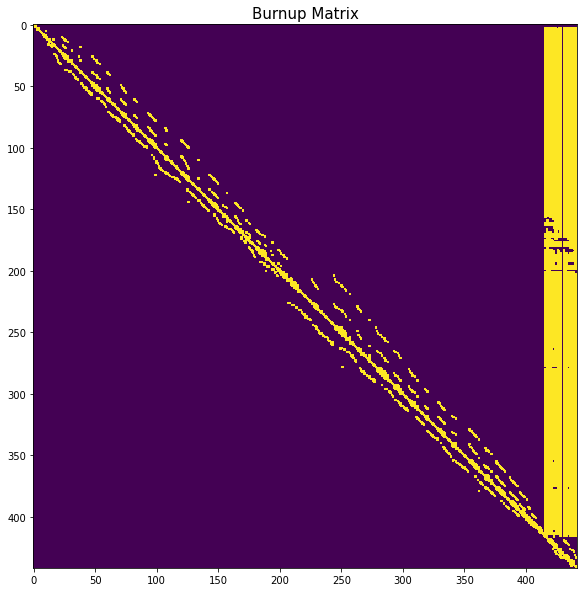

In [71]:
reduced_A = A_bu[idxs][:, idxs]
reduced_nuc = [nuclides[i] for i in idxs]

# Remove Hydrogen and Helium
idxs = []
for i,nuc in enumerate(reduced_nuc):
    if ('H1' in nuc) or ('He4' in nuc):
        print('Removing nuclide', nuc)
        idxs.append(i)
reduced_A = np.delete(np.delete(reduced_A, idxs,0),idxs,1)
reduced_nuc = [reduced_nuc[i] for i,_ in enumerate(reduced_nuc) if not i in idxs]

# Remove zeros
ds = np.diag(reduced_A)
idxs = []
for i,d in enumerate(ds):
    if d == 0.0:
        idxs.append(i)
reduced_A = np.delete(np.delete(reduced_A, idxs,0),idxs,1)
reduced_nuc = [reduced_nuc[i] for i,_ in enumerate(reduced_nuc) if not i in idxs]

print("Finally A has shape", reduced_A.shape)
fig,ax = plt.subplots(figsize = (10,10))

ax.imshow(np.abs(reduced_A),vmax = 1e-100)
ax.set_title("Burnup Matrix", fontsize = fs)
plt.show()

5.229641778152927e-15 0.6478011033270523
[-3.85342944e-12+0.00000000e+00j -1.32093409e-12+0.00000000e+00j
 -4.14066416e-06+0.00000000e+00j -5.93561015e-11+0.00000000e+00j
 -1.31104861e-10+0.00000000e+00j -1.36171781e-09+0.00000000e+00j
 -5.22964178e-15+0.00000000e+00j -2.29671034e-04+0.00000000e+00j
 -2.21145780e-09+0.00000000e+00j -4.64261911e-09+0.00000000e+00j
 -1.39556089e-04+0.00000000e+00j -5.17274015e-02+0.00000000e+00j
 -3.62904283e-02+0.00000000e+00j -2.08152306e-02+0.00000000e+00j
 -2.94705434e-03+0.00000000e+00j -1.26026760e-01+0.00000000e+00j
 -4.84718308e-02+0.00000000e+00j -1.57533450e-01+0.00000000e+00j
 -2.18658417e-02+0.00000000e+00j -4.25504715e-02+0.00000000e+00j
 -1.26026760e-02+0.00000000e+00j -1.24554749e-02+0.00000000e+00j
 -8.08806512e-02+0.00000000e+00j -1.28218124e-03+0.00000000e+00j
 -3.98360449e-03+0.00000000e+00j -3.54369724e-03+0.00000000e+00j
 -6.47801103e-01+0.00000000e+00j -1.54307030e-01+0.00000000e+00j
 -2.56531155e-01+0.00000000e+00j -4.62098120e-01+

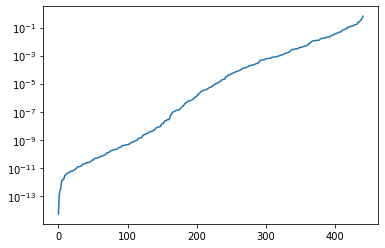

In [73]:
eigvals,_ = np.linalg.eig(reduced_A)
print(np.abs(eigvals).min(), np.abs(eigvals).max())
# print(np.diag(reduced_A))
print(eigvals)
print("stiffness {:.2e}".format(np.max(np.abs(eigvals)) / np.min(np.abs(eigvals))))
plt.plot(np.sort(np.abs(eigvals)))
plt.yscale('log')
plt.show()

#### Compare solutions

In [74]:
reduced_n0 = np.array([n0[i] for i,_ in enumerate(n0) if nuclides[i] in reduced_nuc])
reduced_n1 = np.array([n1[i] for i,_ in enumerate(n1) if nuclides[i] in reduced_nuc])
print(len(reduced_n0))
print(len(reduced_nuc))
print(reduced_A.shape)
N = len(reduced_n0)
print(reduced_nuc)

442
442
(442, 442)
['C14', 'O16', 'O17', 'Zn67', 'Zn68', 'Zn70', 'Zn72', 'Ga69', 'Ga71', 'Ge72', 'Ge73', 'Ge74', 'Ge75', 'Ge76', 'Ge77', 'Ge78', 'As75', 'As77', 'As78', 'As79', 'As81', 'As82', 'As83', 'Se76', 'Se77', 'Se78', 'Se79', 'Se79_m1', 'Se80', 'Se81', 'Se81_m1', 'Se82', 'Se83', 'Se84', 'Se85', 'Se86', 'Se87', 'Br79', 'Br81', 'Br82', 'Br83', 'Br84', 'Br84_m1', 'Br85', 'Br86', 'Br87', 'Br88', 'Br89', 'Kr82', 'Kr83', 'Kr83_m1', 'Kr84', 'Kr85', 'Kr85_m1', 'Kr86', 'Kr87', 'Kr88', 'Kr89', 'Kr90', 'Kr91', 'Rb85', 'Rb86', 'Rb87', 'Rb88', 'Rb89', 'Rb90', 'Rb90_m1', 'Rb91', 'Rb92', 'Rb93', 'Rb94', 'Sr86', 'Sr87', 'Sr88', 'Sr89', 'Sr90', 'Sr91', 'Sr92', 'Sr93', 'Sr94', 'Sr95', 'Sr96', 'Y89', 'Y90', 'Y91', 'Y91_m1', 'Y92', 'Y93', 'Y94', 'Y95', 'Y96', 'Y96_m1', 'Y97', 'Zr90', 'Zr91', 'Zr92', 'Zr93', 'Zr94', 'Zr95', 'Zr96', 'Zr97', 'Zr98', 'Zr99', 'Zr100', 'Zr101', 'Zr102', 'Nb93_m1', 'Nb94', 'Nb95', 'Nb95_m1', 'Nb96', 'Nb97', 'Nb97_m1', 'Nb98', 'Nb98_m1', 'Nb99', 'Nb99_m1', 'Nb100', 'Nb101'

In [75]:
dt = 15768000  # Seconds.
sp.save_npz(matrix_dir + 'reduced_burnup', sp.csc_matrix(reduced_A))
np.savetxt(matrix_dir + 'reduced_n0.txt', 
           reduced_n0, header = "The depletion step is {:.5e} seconds".format(dt))
with open(matrix_dir + 'reduced_nucs.pkl', 'wb') as f:
    pickle.dump(reduced_nuc, f)
           

In [76]:
eigvals,_ = np.linalg.eig(sp.load_npz(matrix_dir + 'reduced_burnup.npz').toarray())
eigvals,_ = np.linalg.eig(reduced_A)
eigvals

array([-3.85342944e-12+0.00000000e+00j, -1.32093409e-12+0.00000000e+00j,
       -4.14066416e-06+0.00000000e+00j, -5.93561015e-11+0.00000000e+00j,
       -1.31104861e-10+0.00000000e+00j, -1.36171781e-09+0.00000000e+00j,
       -5.22964178e-15+0.00000000e+00j, -2.29671034e-04+0.00000000e+00j,
       -2.21145780e-09+0.00000000e+00j, -4.64261911e-09+0.00000000e+00j,
       -1.39556089e-04+0.00000000e+00j, -5.17274015e-02+0.00000000e+00j,
       -3.62904283e-02+0.00000000e+00j, -2.08152306e-02+0.00000000e+00j,
       -2.94705434e-03+0.00000000e+00j, -1.26026760e-01+0.00000000e+00j,
       -4.84718308e-02+0.00000000e+00j, -1.57533450e-01+0.00000000e+00j,
       -2.18658417e-02+0.00000000e+00j, -4.25504715e-02+0.00000000e+00j,
       -1.26026760e-02+0.00000000e+00j, -1.24554749e-02+0.00000000e+00j,
       -8.08806512e-02+0.00000000e+00j, -1.28218124e-03+0.00000000e+00j,
       -3.98360449e-03+0.00000000e+00j, -3.54369724e-03+0.00000000e+00j,
       -6.47801103e-01+0.00000000e+00j, -1.54307030

In [77]:
# CRAM
t_final = 15768000  # Seconds
nstep = 50
ts = np.linspace(0,t_final,nstep)
NsCRAM = np.zeros([nstep, N])
for i in range(nstep):
    NsCRAM[i,:] = CRAM16(sp.csc_matrix(reduced_A),reduced_n0,ts[i])

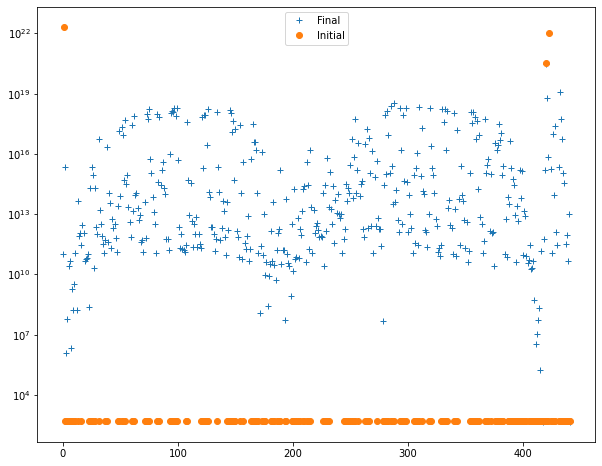

In [80]:
fig,ax = plt.subplots(figsize = (10,8))
# ax.plot(reduced_n1, 'o', label = "Final N1 with normal matrix")
# ax.plot(NsCRAM[-1,:], '+', label = "Final N1 with reduced matrix")
ax.plot(NsCRAM[-1,:], '+', label = "Final")
ax.plot(reduced_n0, 'o', label = 'Initial')
ax.set_yscale('log')
ax.legend()
plt.show()

## Depletion only

In [43]:
A_dep = sp.load_npz("/home/arnau/Downloads/A_matrices_from_openmc/A_0006.npz").toarray()
A_dep

array([[-5.69906211e-214,  2.23705648e-215,  0.00000000e+000, ...,
         0.00000000e+000,  0.00000000e+000,  0.00000000e+000],
       [ 5.69906211e-214, -2.32752165e-215,  5.40181169e-217, ...,
         0.00000000e+000,  0.00000000e+000,  0.00000000e+000],
       [ 0.00000000e+000,  9.04651654e-217, -1.78283365e-009, ...,
         0.00000000e+000,  0.00000000e+000,  0.00000000e+000],
       ...,
       [ 0.00000000e+000,  0.00000000e+000,  0.00000000e+000, ...,
        -3.08065414e+003,  0.00000000e+000,  0.00000000e+000],
       [ 0.00000000e+000,  0.00000000e+000,  0.00000000e+000, ...,
         0.00000000e+000, -3.64814306e+000,  0.00000000e+000],
       [ 0.00000000e+000,  0.00000000e+000,  0.00000000e+000, ...,
         0.00000000e+000,  0.00000000e+000, -1.69060288e+002]])

In [45]:
# Remove values smaller than 1e-200, since they are like zeros
A_dep[np.abs(A_dep) < 1e-200] = 0.0
print("Is triangular?", np.allclose(A_dep, np.tril(A_dep), atol=1e-20) == True)
# It is not triangular, but since it's only depletion it should be triangularisable.

Is triangular? False


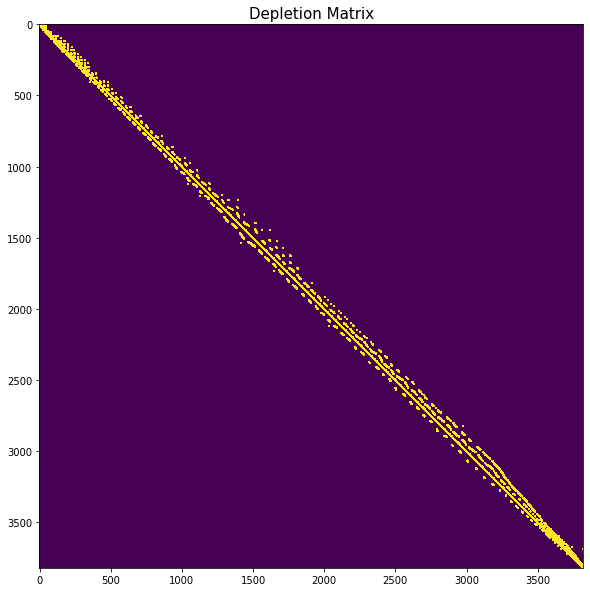

In [46]:
fig,ax = plt.subplots(figsize = (10,10))

ax.imshow(np.abs(A_dep),vmax = 1e-100)
ax.set_title("Depletion Matrix", fontsize = fs)
plt.show()

In [47]:
B = np.copy(A_dep)
idxs = triangularise_matrix(B)
nuclides_tri = [nuclides[idx] for idx in idxs]

In [88]:
with open("nuclides_tri.txt", "wb") as fp:
    pickle.dump(nuclides_tri, fp)

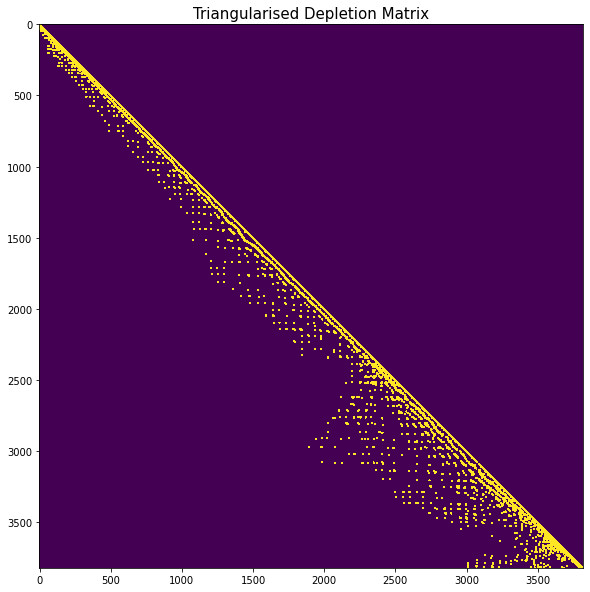

In [48]:
fig,ax = plt.subplots(figsize = (10,10))

ax.imshow(np.abs(B),vmax = 1e-100)
ax.set_title("Triangularised Depletion Matrix", fontsize = fs)
plt.show()

In [49]:
nuclides_tri

['N10',
 'H2',
 'H6',
 'H7',
 'H5',
 'H4',
 'H3',
 'Be5',
 'He10',
 'He5',
 'He7',
 'He6',
 'He9',
 'He8',
 'Li8',
 'B6',
 'C9',
 'Li6',
 'Li12',
 'B7',
 'Li10',
 'Li9',
 'Li11',
 'Be11',
 'Li4',
 'B9',
 'C8',
 'Be9',
 'Be10',
 'Li7',
 'Be13',
 'Be12',
 'Be15',
 'Be16',
 'Be14',
 'He3',
 'B8',
 'Be8',
 'Be6',
 'O12',
 'C11',
 'B12',
 'B13',
 'B14',
 'B16',
 'B15',
 'B18',
 'B17',
 'B19',
 'He4',
 'Li5',
 'N11',
 'B11',
 'N12',
 'N13',
 'C18',
 'C15',
 'C16',
 'C17',
 'C19',
 'N18',
 'C21',
 'C20',
 'C22',
 'H1',
 'C10',
 'N16',
 'C13',
 'C14',
 'F16',
 'F14',
 'N17',
 'F15',
 'N19',
 'N20',
 'N21',
 'N22',
 'N25',
 'N24',
 'N23',
 'B10',
 'O13',
 'Ne16',
 'O15',
 'Na18',
 'Si22',
 'Na19',
 'O19',
 'O20',
 'O21',
 'O22',
 'O23',
 'O28',
 'O27',
 'O26',
 'O25',
 'O24',
 'C12',
 'O14',
 'N15',
 'Mg21',
 'Al22',
 'Al21',
 'F20',
 'F21',
 'F22',
 'F23',
 'F24',
 'F25',
 'F26',
 'F27',
 'F28',
 'F30',
 'F29',
 'F31',
 'N14',
 'Mg19',
 'Ne18',
 'Mg20',
 'Na20',
 'P24',
 'Si23',
 'Ne23',
 'Ne2

Number of zero eigvals: 277
λmin =  -3.0136833937388922e+22
λmax =  -1.293185038358107e-28


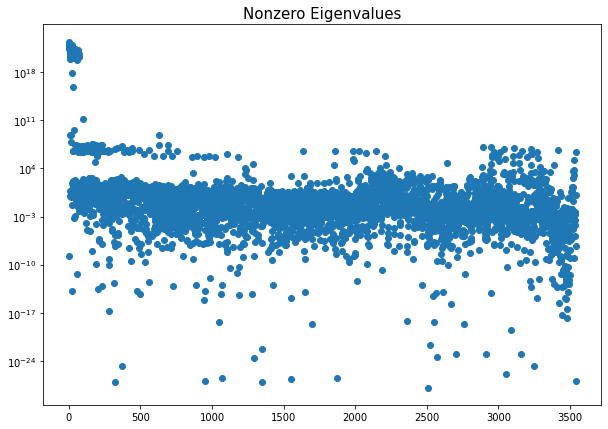

In [87]:
lams = np.diag(B)
print("Number of zero eigvals:", len(np.where(lams == 0.0)[0]))
lams = lams[np.where(lams != 0.0)]
print("λmin = ", np.min(lams))
print("λmax = ", np.max(lams))
fig,ax = plt.subplots(figsize = (10,7))
ax.plot(np.abs(lams), "o")
ax.set_yscale("log")
ax.set_title("Nonzero Eigenvalues", fontsize = fs)
plt.show()

## Compare to endb71 matrix provided by Jiri 

In [50]:
A_Jiri = sp.load_npz("/home/arnau/Downloads/endfb71.npz").toarray()
A_Jiri

array([[    0.    ,     0.    ,     0.    , ...,     0.    ,     3.6481,
            0.    ],
       [    0.    ,     0.    ,     0.    , ...,     0.    ,     0.    ,
            0.    ],
       [    0.    ,     0.    ,     0.    , ...,     0.    ,     0.    ,
            0.    ],
       ...,
       [    0.    ,     0.    ,     0.    , ..., -3080.7   ,     0.    ,
            0.    ],
       [    0.    ,     0.    ,     0.    , ...,     0.    ,    -3.6481,
            0.    ],
       [    0.    ,     0.    ,     0.    , ...,     0.    ,     0.    ,
         -169.06  ]])

In [52]:
A_Jiri.shape

(3822, 3822)

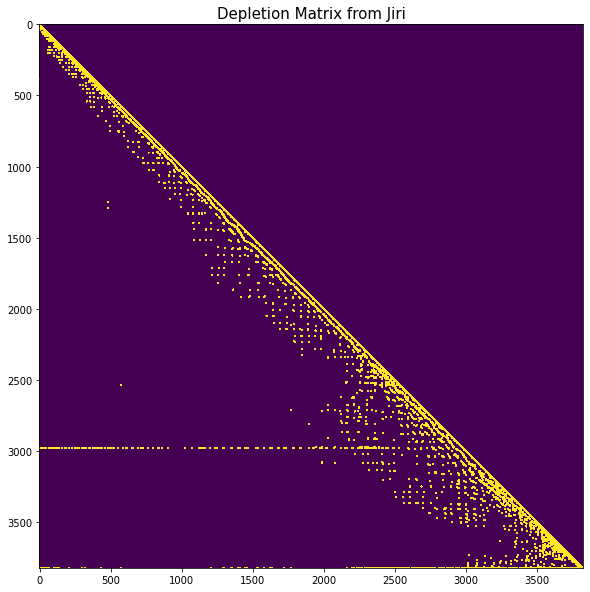

In [90]:
fig,ax = plt.subplots(figsize = (10,10))

ax.imshow(np.abs(A_Jiri), vmax = 1e-100)
ax.set_title("Depletion Matrix from Jiri", fontsize = fs)
plt.show()

In [89]:
triangularise_matrix(A_Jiri)

array([ 578,   25,    2, ..., 3126,    0,    9])